# Drawing

## (1) 盒鬚圖
不同隱藏層神經元數量 (n=[1,20])下的 30 次建模結果盒鬚圖

In [1]:
from module.draw.draw import display_boxplot
name_test = "2024_0604_2219_part2"

[0.0009559  0.00078898 0.00091577 0.00063103 0.00102723 0.00089984
 0.00101603 0.00065723 0.0011673  0.00090281 0.00102591 0.00096605
 0.00110471 0.00083791 0.00094062 0.00078605 0.00080589 0.00058667
 0.00088006 0.00074397 0.0014654  0.0009342  0.00118601 0.00103067
 0.00103852 0.00074187 0.00083937 0.00116688 0.00060839 0.00083238]


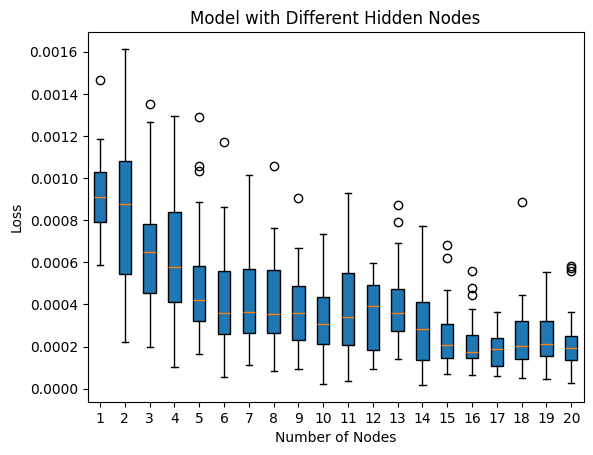

In [2]:
ttl_loss_in = display_boxplot(name_test, type_loss=0)
# ttl_loss_in

[0.00094382 0.00078024 0.00090419 0.00062605 0.00101432 0.00088817
 0.00100352 0.00065057 0.00115221 0.0008917  0.00101255 0.00095343
 0.00109028 0.00082741 0.00092971 0.00077747 0.00079694 0.00058319
 0.00087062 0.00073658 0.00144719 0.00092268 0.00117092 0.00101781
 0.00102606 0.00073526 0.00082891 0.0011517  0.00060451 0.00082204]


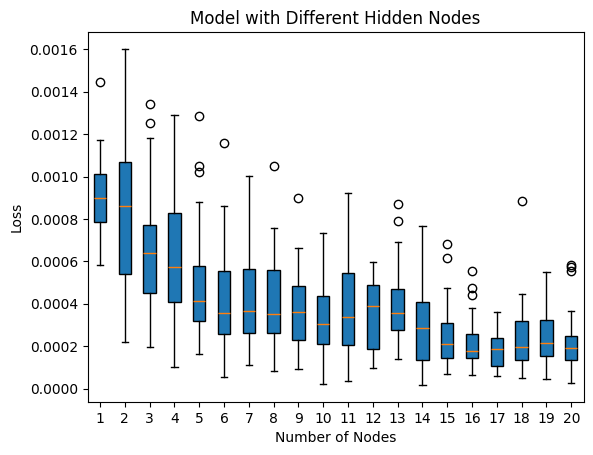

In [3]:
ttl_loss_out = display_boxplot(name_test, type_loss=1)
# ttl_loss_out

由上面兩張圖可以看出， <br>
無論是 best in-sample loss 或 best out-of-sample loss， <br>
當 n=16 時，其 loss 的平均、盒子的寬度，皆為最小值。<br>
<br>
故接下來探討 <b>n=16</b> 時的狀況。

## (2) 真實 vs 預測
最佳隱藏層數量下，30 次建模結果最佳解的真實與預測解比較

In [4]:
import numpy as np
from module.for_model.checkpoint import get_best_model
from module.for_dataset.create_dataset import create_dataset
from module.for_dataset.normalization import normalization

### 調出 best model 的 best checkpoint 的參數

In [5]:
name_experiment = "2024_0604_2219_part2"
n = 16
nn_best, _ = get_best_model(name_experiment, n)

### 建立其他沒看過的資料

In [6]:
# 建立其他沒看過的資料
# (之前 random seed 設 0，這次要設不一樣)

random_seed = 1
num_analysis = 5
num_data = int(num_analysis/0.8)

X, Y, _, _ = create_dataset(random_seed, num_data, "sum")

# reshape for the model output
Y = Y.reshape((-1,1))

# normalize
normalizer = normalization(X)
X_n = normalizer.normalize(X)
Y_n = normalizer.normalize(Y)

X_n

array([[0.        , 0.65413038],
       [0.08841383, 1.        ],
       [0.3510161 , 0.63618369],
       [0.99181842, 0.42583795],
       [0.68105041, 0.67814727]])

### 比較不同輸入時，預測值、真實值的差異

In [7]:
# 稍微計算一下 loss
loss_average = nn_best.evaluate(X_n, Y_n)
loss_average

0.0011302780887765384

In [8]:
# 比較輸入、預測值、標籤
diff = np.zeros(num_analysis, dtype=int)
for x, y, idx in zip(X, Y, range(num_analysis)):
    x_n = normalizer.normalize(x)
    pred = nn_best.forward([x_n])[0]
    y_pred = normalizer.unnormalize(pred)
    y_pred = y_pred.round()
    
    diff[idx] = y[0] - y_pred[0]
    print(f"x = {x}, y_pred = {y_pred[0]}, y = {y[0]}")

diff

x = [1235 6192], y_pred = 7072.0, y = 7427
x = [1905 8813], y_pred = 10309.0, y = 10718
x = [3895 6056], y_pred = 9640.0, y = 9951
x = [8751 4462], y_pred = 12839.0, y = 13213
x = [6396 6374], y_pred = 12425.0, y = 12770


array([355, 409, 311, 374, 345])

誤差「比例」雖不大，但「值」差很多，我猜可能 train 的時候可以選擇下面其中一個方式（意義差不多）
1. learning rate 可以調大一點，
2. loss 應該用 unnormalied 的 data 算

## (3) 學習曲線
最佳隱藏層數量下，30 次建模結果最佳解的學習曲線

In [9]:
import numpy as np
from module.for_model.checkpoint import get_best_model, load_checkpoint
import matplotlib.pyplot as plt

#### 調出 best model 的所有 checkpoint

In [10]:
name_experiment = "2024_0604_2219_part2"
n = 16
_, idx_best = get_best_model(name_experiment, n)
idx_best

14

In [11]:
path_folder = f"checkpoints\\{name_experiment}\\node_{n:02d}"
ttl_loss = load_checkpoint(path_folder, "loss")
ttl_loss = np.array(ttl_loss)
ttl_loss.shape

(30, 1001, 2)

#### 畫圖

In [12]:
x = range(ttl_loss.shape[1])
y_loss_in = ttl_loss[idx_best,:,0]      # in-sample loss        # 紅色
y_loss_out = ttl_loss[idx_best,:,1]     # out-of-sample loss    # 藍色

##### 觀察整體
看起來學習曲線下降得非常快

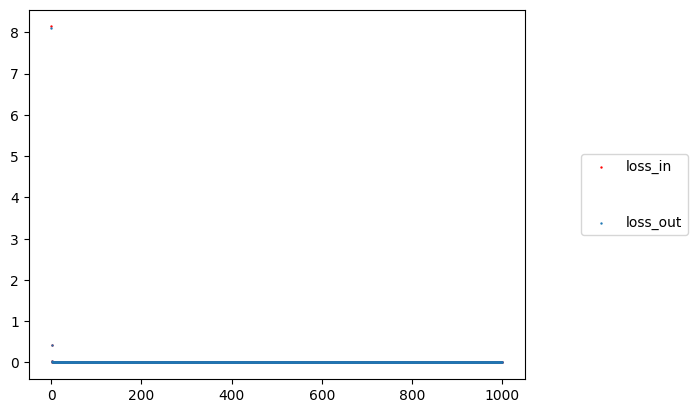

In [13]:
plt.scatter(x, y_loss_in, s=0.5, label="loss_in", color="r")
plt.scatter(x, y_loss_out, s=0.5, label="loss_out")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), labelspacing=3)

##### 觀察前期
前途曾經發生 loss_out 低於 loss_in 的狀況，很有趣。

(0.002, 0.005)

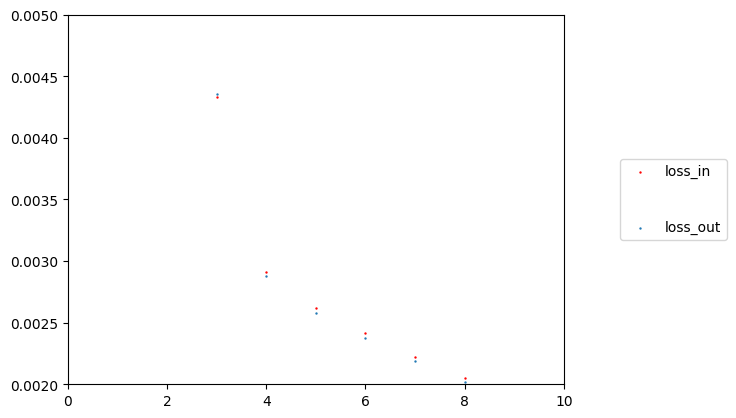

In [14]:
plt.scatter(x, y_loss_in, s=0.5, label="loss_in", color="r")
plt.scatter(x, y_loss_out, s=0.5, label="loss_out")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), labelspacing=3)
plt.xlim([0,10])
plt.ylim([0.002,0.005])

##### 觀察轉折點
loss_out 逐漸高於 loss_in，但仍在下降。可能代表有一點 overfitting?

(9e-05, 0.000105)

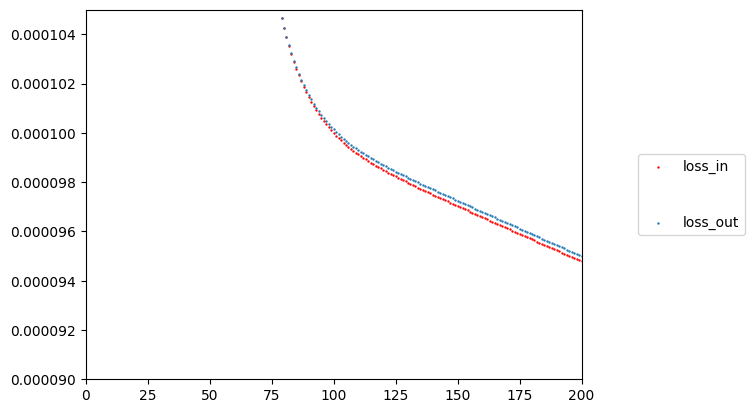

In [15]:
plt.scatter(x, y_loss_in, s=0.5, label="loss_in", color="r")
plt.scatter(x, y_loss_out, s=0.5, label="loss_out")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), labelspacing=3)
plt.xlim([0,200])
plt.ylim([0.00009,0.000105])

##### 觀察後期
loss_out 又低於 loss_in 了，不確定原因。

(6.5e-05, 6.8e-05)

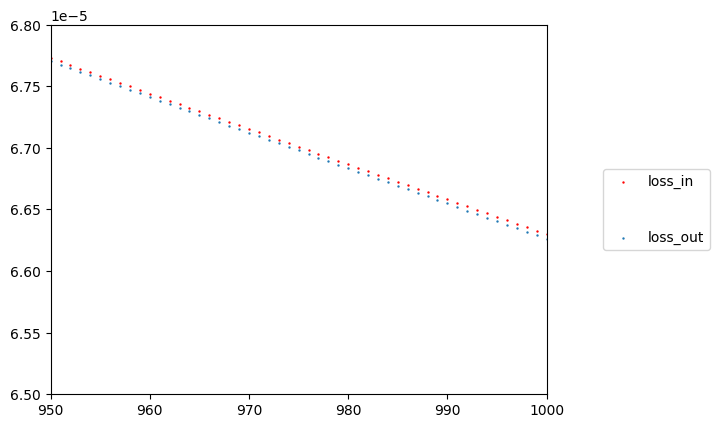

In [16]:
plt.scatter(x, y_loss_in, s=0.5, label="loss_in", color="r")
plt.scatter(x, y_loss_out, s=0.5, label="loss_out")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), labelspacing=3)
plt.xlim([950,1000])
plt.ylim([6.5e-5,6.8e-5])

## (4) Error Histogram
最佳隱藏層數量下，30 次建模結果最佳解的 Error Histogram。

In [17]:
import numpy as np
from module.for_model.checkpoint import get_best_model
from module.for_dataset.create_dataset import create_dataset
from module.for_dataset.normalization import normalization
import matplotlib.pyplot as plt

### 調出 best model 的 best checkpoint 的參數

In [18]:
name_experiment = "2024_0604_2219_part2"
n = 16
nn_best, _ = get_best_model(name_experiment, n)

### 建立其他沒看過的資料

In [19]:
# 建立其他沒看過的資料
# (之前 random seed 設 0，這次要設不一樣)

random_seed = 2
num_analysis = 10000
num_data = int(num_analysis/0.8)

X, Y, _, _ = create_dataset(random_seed, num_data, "sum")

# reshape for the model output
Y = Y.reshape((-1,1))

# normalize
normalizer = normalization(X)
X_n = normalizer.normalize(X)
Y_n = normalizer.normalize(Y)

X_n

array([[0.81529229, 0.28617471],
       [0.12213825, 0.5301178 ],
       [0.3081796 , 0.57423872],
       ...,
       [0.80862414, 0.45010002],
       [0.11924872, 0.61213603],
       [0.73916426, 0.93231829]])

### 取得 error

In [20]:
# 取得 error
ttl_error = np.zeros(num_analysis, dtype=int)
for x_n, y, idx in zip(X_n, Y, range(num_analysis)):
    pred = nn_best.forward([x_n])
    y_pred = normalizer.unnormalize(pred)
    y_pred = y_pred.round()
    ttl_error[idx] = y[0] - y_pred[0,0]
ttl_error

array([-91, -44, -90, ..., -90, -60, 170])

(array([4047., 2633., 1318.,  820.,  534.,  349.,  193.,   51.,   36.,
          19.]),
 array([-113. ,  -50.4,   12.2,   74.8,  137.4,  200. ,  262.6,  325.2,
         387.8,  450.4,  513. ]),
 <BarContainer object of 10 artists>)

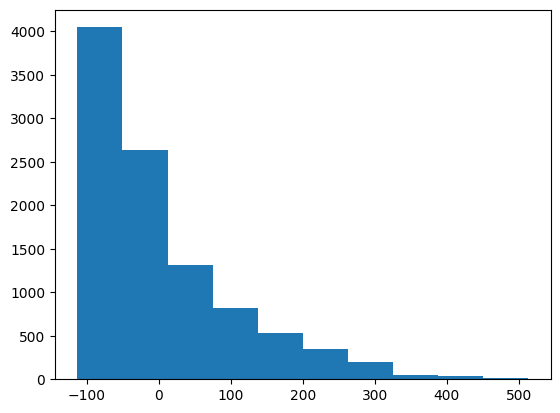

In [21]:
# 畫圖
plt.hist(ttl_error)

從長調圖可以看出，大概四成的情況下，預測值都比真實值大